# Inventory Monitoring Strategy

Summary:
* The code defines a Random class that generates random numbers based on a normal distribution.
* `The generate_demand` function creates a list of demand values for a specified number of periods.
* `calc_demand` calculates the demand for a specific week using a multiplier.
* `calculate_slope` calculates the slope of a linear regression line fitted to a given set of sales data.
* `simulate_player_strategy` simulates a player's pricing strategy over a period, adjusting prices based on demand and slope.
* `calcRev` calculates revenue based on demand and pricing strategies.
* `perfect_foresight` calculates the maximum possible revenue with perfect knowledge of future demand.
* `analyze_slope_range` determines the minimum and maximum slopes based on generated demand data.
* `find_optimal_slope` finds the optimal slope threshold for adjusting prices based on simulated player revenue.
* `play_game_n_times` simulates the game for different wait weeks, finding the optimal slope for each and saving the results to a DataFrame.
* `save_results_to_excel` saves the simulation results to an Excel file.
* The main part of the code runs the simulation for a specified number of iterations, saves the results to an Excel file, and prints a message indicating the completion of the process.

In [31]:
import numpy as np
import pandas as pd
from openpyxl import Workbook

class Random:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        
    def normal(self, mean, stddev):
        return self.rng.normal(mean, stddev)

def generate_demand(periods=15):
    D = []
    b = 90
    c = 0.3 * b
    e = Random()
    while True:
        a = e.normal(b, c)
        if a > 0:
            break
    b = a
    D.append(a)
    c = min(30, 0.3 * b)
    for _ in range(1, periods):
        while True:
            a = e.normal(b, c)
            if a > 0:
                break
        D.append(a)
    return D

def calc_demand(D, week, multiplier):
    return D[week] * multiplier

def calculate_slope(sales):
    if len(sales) < 2:
        return 0
    x = np.arange(len(sales))
    y = np.array(sales)
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

def simulate_player_strategy(threshold, periods=15, wait_weeks=1):
    D = generate_demand(periods)
    mult = [1, 1.3, 1.75, 2.8]
    prices = [60, 54, 48, 36]
    current_price_index = 0
    I = 2000
    revenue = 0
    sales = []
    price_clicks = [0, 0, 0, 0]
    last_price_change_week = -wait_weeks  # Initialize to allow immediate first change

    for week in range(periods):
        if week >= 3:
            recent_sales = sales[-3:]
            slope = calculate_slope(recent_sales)
            if slope < threshold and (week - last_price_change_week) >= wait_weeks:
                if price_clicks[current_price_index] > 0:
                    current_price_index = min(current_price_index + 1, len(prices) - 1)
                    last_price_change_week = week  # Update the last price change week

        current_price = prices[current_price_index]
        current_multiplier = mult[current_price_index]
        weekly_demand = calc_demand(D, week, current_multiplier)
        actual_sales = min(weekly_demand, I)
        revenue += current_price * actual_sales
        I -= actual_sales
        sales.append(actual_sales)

        price_clicks[current_price_index] += 1

        if I <= 0:
            break

    return revenue, D


def calcRev(D, a, b, c, periods, mult, salvage=0):
    e = 0
    d = 2000
    for f in range(a):
        g = min(D[f] * mult[0], d)
        d -= g
        e += 60 * g
    for f in range(a, a + b):
        g = min(D[f] * mult[1], d)
        d -= g
        e += 54 * g
    for f in range(a + b, a + b + c):
        g = min(D[f] * mult[2], d)
        d -= g
        e += 48 * g
    for f in range(a + b + c, periods):
        g = min(D[f] * mult[3], d)
        d -= g
        e += 36 * g
    return e + d * salvage

def perfect_foresight(D, periods, mult):
    e = 0
    for a in range(1, periods + 1):
        for b in range(0, periods - a + 1):
            for c in range(0, periods - a - b + 1):
                d = calcRev(D, a, b, c, periods, mult)
                if d > e:
                    e = d
    return e

def analyze_slope_range(n):
    slopes = []
    for _ in range(n):
        D = generate_demand()
        sales = []
        for week in range(15):
            sales.append(D[week])
            if len(sales) >= 3:
                slope = calculate_slope(sales[-3:])
                slopes.append(slope)
    min_slope = min(slopes)
    max_slope = max(slopes)
    return min_slope, max_slope

def find_optimal_slope(n, slope_range, wait_weeks=1):
    best_threshold = None
    best_difference = float('inf')
    mult = [1, 1.3, 1.75, 2.8]
    thresholds = np.linspace(slope_range[0], slope_range[1], 201)

    for threshold in thresholds:
        total_difference = 0
        for i in range(n):
            player_revenue, D = simulate_player_strategy(threshold, wait_weeks=wait_weeks)
            perfect_revenue = perfect_foresight(D, 15, mult)
            difference = perfect_revenue - player_revenue
            total_difference += difference
        avg_difference = total_difference / n
        if avg_difference < best_difference:
            best_difference = avg_difference
            best_threshold = threshold

    return best_threshold

def play_game_n_times(n, threshold_range):
    results = []
    mult = [1, 1.3, 1.75, 2.8]

    for wait_weeks in range(1, 5):
        optimal_slope = find_optimal_slope(n, threshold_range, wait_weeks=wait_weeks)
        for i in range(n):
            player_revenue, D = simulate_player_strategy(optimal_slope, wait_weeks=wait_weeks)
            perfect_revenue = perfect_foresight(D, 15, mult)
            difference = perfect_revenue - player_revenue
            difference_percentage = difference / perfect_revenue * 100

            results.append({
                'Attempt': i + 1,
                'Wait Weeks': wait_weeks,
                'Player Revenue': player_revenue,
                'Perfect Revenue': perfect_revenue,
                'Difference': difference,
                'Difference Percentage': difference_percentage
            })

    return results

def save_results_to_excel(results, filename='game_results.xlsx'):
    df = pd.DataFrame(results)
    df.to_excel(filename, index=False)

# Analyze slope range based on preliminary demand data
n_analyze = 1000
slope_range = analyze_slope_range(n_analyze)
print(f"Slope Range: {slope_range}")

# Run the simulation with different wait weeks and save the results
n_simulate = 100
results = play_game_n_times(n_simulate, slope_range)
save_results_to_excel(results)

print(f"Results saved to 'game_results.xlsx'")


Slope Range: (-71.44668219686983, 80.1625111234615)
Results saved to 'game_results.xlsx'


In [32]:
df = pd.DataFrame(results)


In [33]:
# print whisker plot for wait week 1, 2, 3, 4
import seaborn as sns
import matplotlib.pyplot as plt

#filter df for each wait week
df1 = df[df['Wait Weeks'] == 1]
print("Results when waiting 1 week before making a price change")
df1.describe()

# Mean diff%= 11.4%


Results when waiting 1 week before making a price change


,Attempt,Wait Weeks,Player Revenue,Perfect Revenue,Difference,Difference Percentage
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
mean,50.500000,1.0,88345.058419,98592.408290,10247.349871,11.404490
std,29.011492,0.0,19577.310662,17667.199842,5764.448561,8.185717
min,1.000000,1.0,5599.418510,9161.982520,76.000931,0.073994
25%,25.750000,1.0,83688.502930,91200.605559,5662.250496,5.407074
50%,50.500000,1.0,94072.614317,103007.705820,9170.342653,8.911870
75%,75.250000,1.0,101153.648965,110045.489526,14412.532740,14.412454
max,100.000000,1.0,111184.446990,120000.000000,24401.441077,38.884204


In [34]:
df2 = df[df['Wait Weeks'] == 2]
print("Results when waiting 2 weeks before making a price change")
df2.describe()

# Mean diff = 11.13%


Results when waiting 2 weeks before making a price change


,Attempt,Wait Weeks,Player Revenue,Perfect Revenue,Difference,Difference Percentage
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
mean,50.500000,2.0,86307.269786,96797.565766,10490.295980,11.137794
std,29.011492,0.0,19011.075762,20078.902722,4546.489103,4.636590
min,1.000000,2.0,9865.611014,11566.095283,1700.484270,2.670499
25%,25.750000,2.0,81783.827231,91126.572089,7273.205386,7.938024
50%,50.500000,2.0,92631.970556,101669.761891,10367.827430,10.583852
75%,75.250000,2.0,97351.354733,108718.138190,13167.309947,14.607222
max,100.000000,2.0,109783.570836,120000.000000,23914.208385,25.771373


In [35]:
df3 = df[df['Wait Weeks'] == 3]
print("Results when waiting 3 weeks before making a price change")
df3.describe()

# Mean diff = 10.2%

Results when waiting 3 weeks before making a price change


,Attempt,Wait Weeks,Player Revenue,Perfect Revenue,Difference,Difference Percentage
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
mean,50.500000,3.0,86768.338086,96279.081998,9510.743912,10.200017
std,29.011492,0.0,17563.271317,18277.340867,3863.651562,4.342337
min,1.000000,3.0,21960.318549,27158.633342,2022.929318,2.236636
25%,25.750000,3.0,81071.497790,88849.665153,6281.877827,6.833847
50%,50.500000,3.0,92181.626165,98951.460235,9683.187332,9.837254
75%,75.250000,3.0,97847.937197,108650.010844,12103.956442,12.393248
max,100.000000,3.0,106472.069983,120000.000000,21257.917463,22.622779


In [36]:
df4 = df[df['Wait Weeks'] == 4]
print("Results when waiting 4 weeks before making a price change")
df4.describe()

# Mean diff = 9.75%

Results when waiting 4 weeks before making a price change


,Attempt,Wait Weeks,Player Revenue,Perfect Revenue,Difference,Difference Percentage
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
mean,50.500000,4.0,89079.696983,98346.006194,9266.309211,9.753704
std,29.011492,0.0,16838.602603,17316.443363,3259.861732,3.991584
min,1.000000,4.0,27452.391688,33956.242638,3090.119625,3.354292
25%,25.750000,4.0,87375.719530,92266.438043,6690.318137,6.861809
50%,50.500000,4.0,95754.784444,102670.351314,9380.323014,9.477430
75%,75.250000,4.0,99402.058193,110085.846055,11416.267529,11.739456
max,100.000000,4.0,106835.168833,120000.000000,16439.681081,19.153624


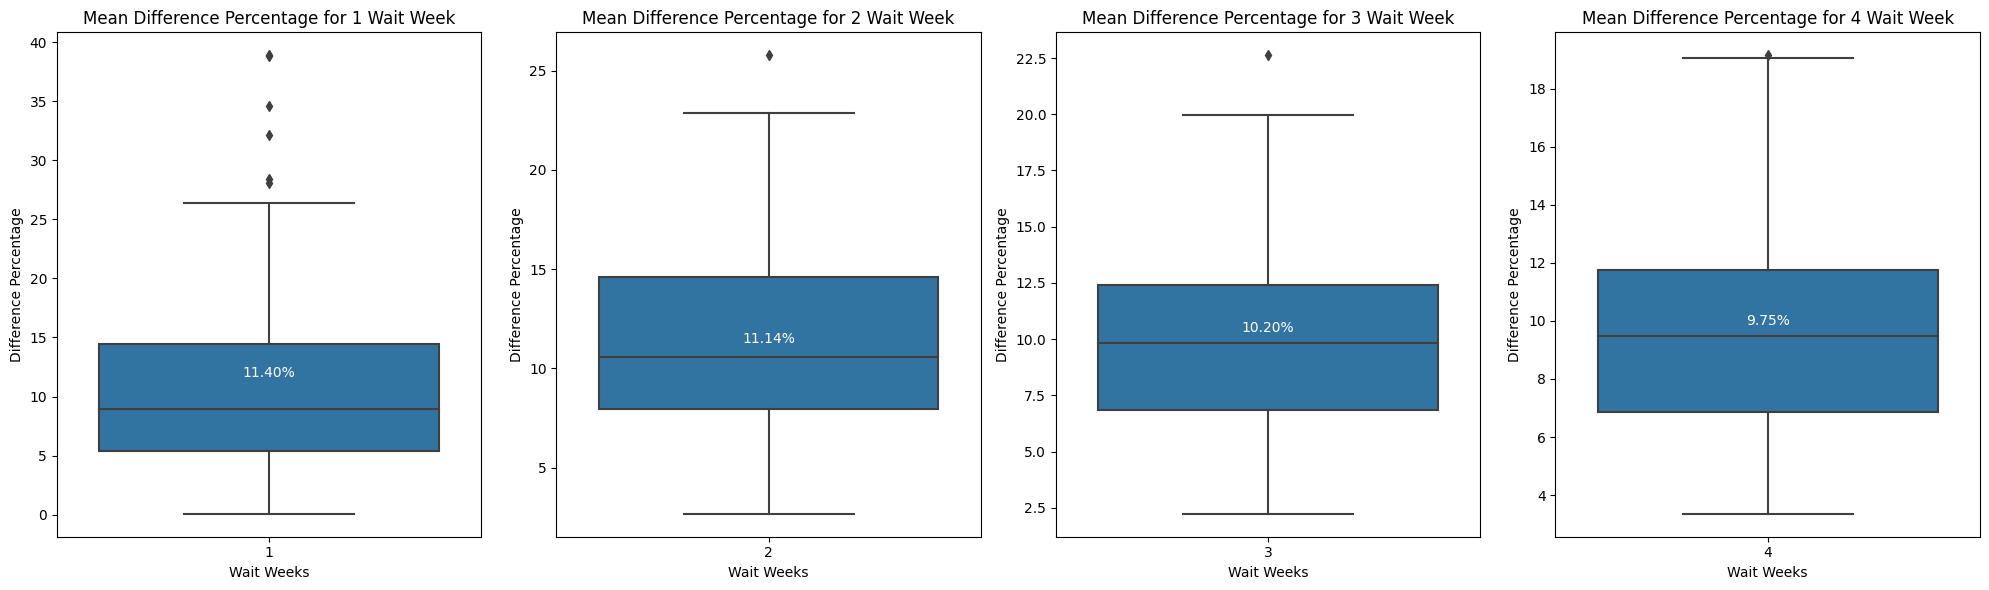

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_list contains the dataframes df1, df2, df3, and df4
df_list = [df1, df2, df3, df4]

# Create a single figure with four subplots arranged in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Iterate through the list of dataframes and plot each on its corresponding subplot
for i, (df, ax) in enumerate(zip(df_list, axes), start=1):
    sns.boxplot(data=df, x='Wait Weeks', y='Difference Percentage', ax=ax)
    ax.set_title(f'Mean Difference Percentage for {i} Wait Week')
    
    # Calculate the mean for each group
    mean_values = df.groupby('Wait Weeks')['Difference Percentage'].mean()
    
    # Add mean labels to the plot
    for j, mean_value in enumerate(mean_values, start=1):
        ax.text(j - 1, mean_value, f'{mean_value:.2f}%', ha='center', va='bottom', fontsize=10, color='white')

# Adjust layout
plt.tight_layout()
plt.show()